## Problem statement
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('./Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('./Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
# Creating Train dataset using tf.keras.preprocessing.image_dataset_from_directory utility 
# and using a seed of 123 along with some other parameters

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    
    data_dir_train,
    validation_split = 0.2,
    seed = 123,
    subset = "training",
    image_size = (img_height, img_width),
    batch_size = batch_size

)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# Creating Validation dataset using tf.keras.preprocessing.image_dataset_from_directory utility 
# and using a seed of 123 along with some other parameters
val_ds = tf.keras.preprocessing.image_dataset_from_directory (
    
    data_dir_train,
    validation_split = 0.2,
    seed = 123,
    subset = "validation",
    image_size = (img_height, img_width),
    batch_size = batch_size

)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# Listing all the class names

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


2025-02-16 13:22:17.149984: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


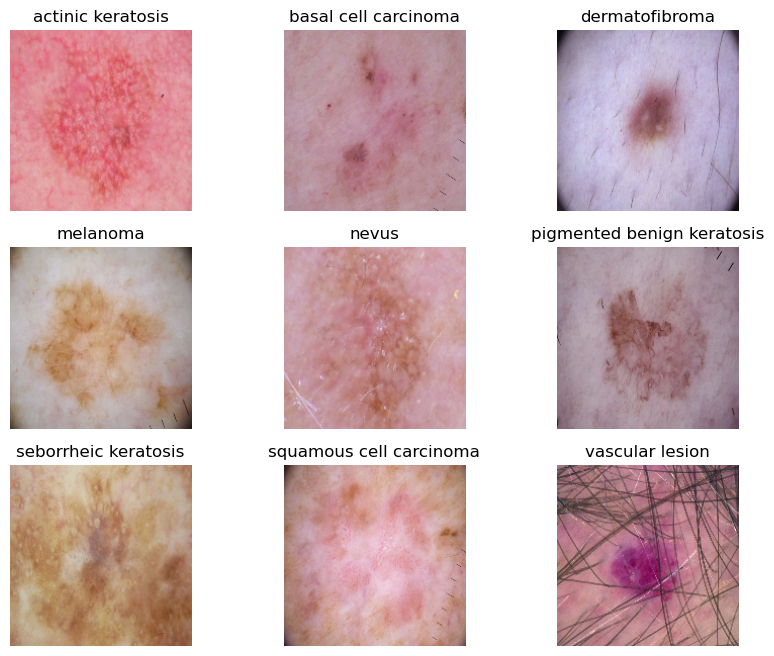

In [12]:
# Using a filter to match class labels in train_ds and pick one image for each class from the train_ds dataset

plt.figure(figsize=(10,8))
for idx in range(len(class_names)):
  filtered_ds = train_ds.filter(lambda img, lbl : tf.math.equal(lbl[0], idx))
  for image, label in filtered_ds.take(1):
    ax = plt.subplot(3, 3,idx+1)
    plt.imshow(image[0].numpy().astype('uint8'))
    plt.title(class_names[label[0].numpy()])
    plt.axis('off')



The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
Will proceed to now create a CNN model, which can accurately detect 9 classes present in the dataset. Uisng ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:

num_classes = len(class_names)

model = Sequential()

# Input Layer
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# First Convolution layer with 16 filters of 3 X 3
model.add(layers.Conv2D(16, kernel_size = (3,3), padding = "same", activation = "relu"))

# Pooling Layer
model.add(layers.MaxPooling2D(pool_size = (2,2)))

# Second Convolution layer
model.add(layers.Conv2D(32, kernel_size =  (3,3), padding =  "same", activation = "relu"))

# Pooling Layer
model.add(layers.MaxPooling2D(pool_size = (2,2)))

# Third Convolution layer
model.add(layers.Conv2D(64, kernel_size =  (3,3), padding =  "same", activation = "relu"))

# Pooling Layer
model.add(layers.MaxPooling2D(pool_size = (2,2)))

# Flatten the image vector before passing to dense layer
model.add(layers.Flatten())

# Dense Fully Connected Layer
model.add(layers.Dense(128, activation = "relu"))

# Softmax Layer
model.add(layers.Dense(num_classes, activation = "softmax"))



### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
# Adam optimiser and SparseCategoricalCrossEntropy loss function is chosen
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.2041 - loss: 2.1534 - val_accuracy: 0.2729 - val_loss: 1.9149
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.3346 - loss: 1.8077 - val_accuracy: 0.4765 - val_loss: 1.5052
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.4899 - loss: 1.4635 - val_accuracy: 0.4609 - val_loss: 1.5378
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5091 - loss: 1.4333 - val_accuracy: 0.5145 - val_loss: 1.3898
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5395 - loss: 1.2869 - val_accuracy: 0.5459 - val_loss: 1.3020
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.5931 - loss: 1.1667 - val_accuracy: 0.5526 - val_loss: 1.3083
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6093 - loss: 1.0864 - val_accuracy: 0.5347 - val_loss: 1.4536
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6418 - loss: 0.9877 - val_accuracy: 0.5369 - v

### Visualizing training results

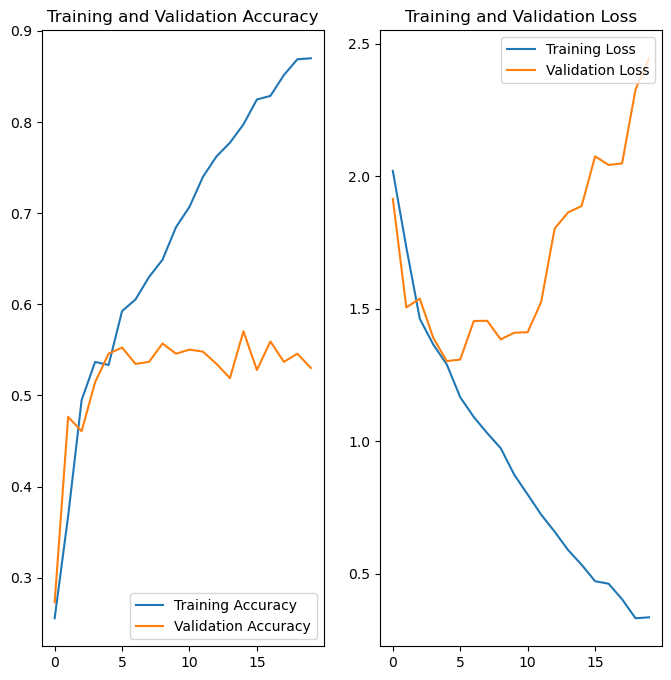

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings after first model

- It is clearly evident from the plot that there is a significant difference between the train accuracy and validation accuracy
- The validation accuracy has not increased beyond 53%
- Also there is a significant difference between training and validation loss
- The model has a clear sign of overfitting
- The model would require some regularization and augmentation to close the gap and optimize.

In [20]:
# Performing Data Augmentation using Keras Image Preprocessing Augmentation layers

image_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3),    
    layers.RandomShear(0.1, 0.1),
    
  ]
)


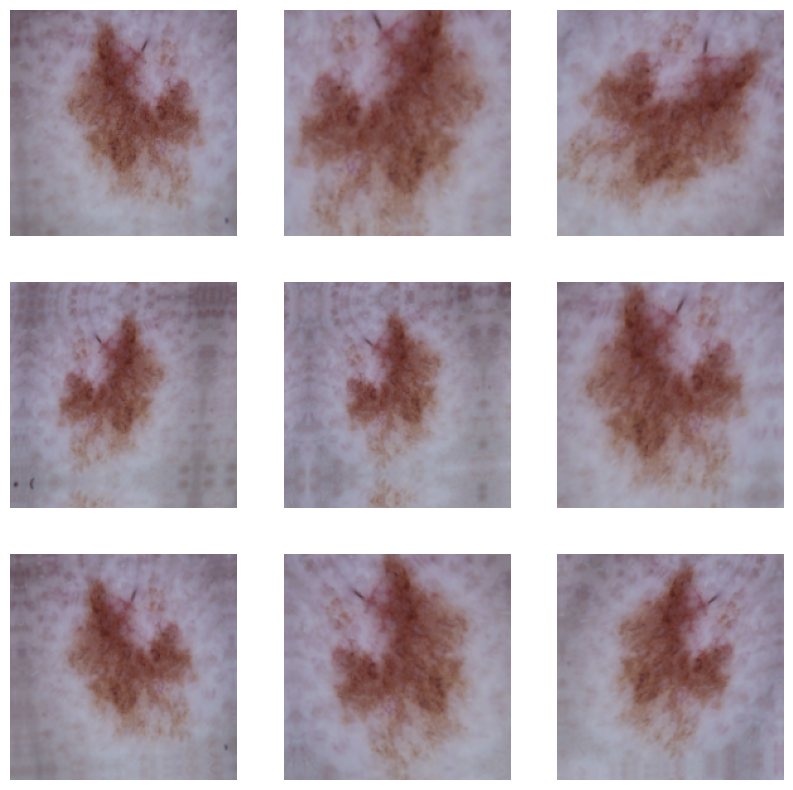

In [21]:
# Visualizing how the augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    augmented_images = image_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the second model with augmentation and dropout


In [22]:
num_classes = len(class_names)

model = Sequential()

# Augmentation layer

model.add(image_augmentation)

# Input Layer
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# First Convolution layer with 16 filters of 3 X 3
model.add(layers.Conv2D(16, kernel_size = (3,3), padding = "same", activation = "relu"))

# Pooling Layer
model.add(layers.MaxPooling2D(pool_size = (2,2)))

# Dropout Layer
model.add(layers.Dropout(0.2))

# Second Convolution layer
model.add(layers.Conv2D(32, kernel_size =  (3,3), padding =  "same", activation = "relu"))

# Pooling Layer
model.add(layers.MaxPooling2D(pool_size = (2,2)))

# Dropout Layer
model.add(layers.Dropout(0.2))

# Third Convolution layer
model.add(layers.Conv2D(64, kernel_size =  (3,3), padding =  "same", activation = "relu"))

# Pooling Layer
model.add(layers.MaxPooling2D(pool_size = (2,2)))

# Dropout Layer
model.add(layers.Dropout(0.2))

# Flatten the image vector before passing to dense layer
model.add(layers.Flatten())

# Dense Fully Connected Layer
model.add(layers.Dense(128, activation = "relu"))

# Softmax Layer
model.add(layers.Dense(num_classes, activation = "softmax"))



### Compiling the model

In [23]:
# Adam optimiser and SparseCategoricalCrossEntropy loss function is chosen
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [24]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.1746 - loss: 3.0922 - val_accuracy: 0.2170 - val_loss: 2.0799
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.1982 - loss: 2.0308 - val_accuracy: 0.2886 - val_loss: 2.0135
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.2679 - loss: 1.9644 - val_accuracy: 0.3758 - val_loss: 1.8742
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.2878 - loss: 1.9476 - val_accuracy: 0.4116 - val_loss: 1.7128
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.4058 - loss: 1.6474 - val_accuracy: 0.4228 - val_loss: 1.7448
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.4311 - loss: 1.5852 - val_accuracy: 0.4004 - val_loss: 1.6432
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.4488 - loss: 1.5665 - val_accuracy: 0.3803 - val_loss: 1.7532
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.4686 - loss: 1.4994 - val_accuracy: 0.4228 - v

### Visualizing the results

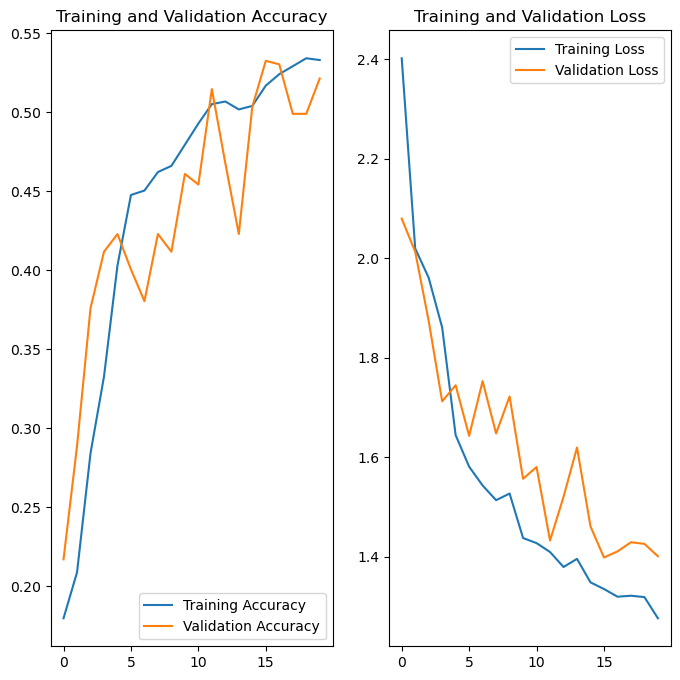

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings after second model

- The model train and validation accuracy gap is closer
- The train and validation losses gap is also closer
- This means that the augmentation and regularization technique had been useful
- Overall train accuracy not going above 53%
- This means the model is not effectively learning all the patterns and there might be some class imbalance

#### We need to find the distribution of classes in the training dataset.
#### **Context:** 
Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
# Will traverse through the image directories and sub-directories and pair each image (in the path) with its class label (sub-directory)
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict_original = dict(zip(path_list, lesion_list))
image_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
image_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,melanoma
1,Skin cancer ISIC The International Skin Imagin...,melanoma
2,Skin cancer ISIC The International Skin Imagin...,melanoma
3,Skin cancer ISIC The International Skin Imagin...,melanoma
4,Skin cancer ISIC The International Skin Imagin...,melanoma
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
2235,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
2236,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
2237,Skin cancer ISIC The International Skin Imagin...,dermatofibroma


In [27]:
image_df["Label"].value_counts()

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

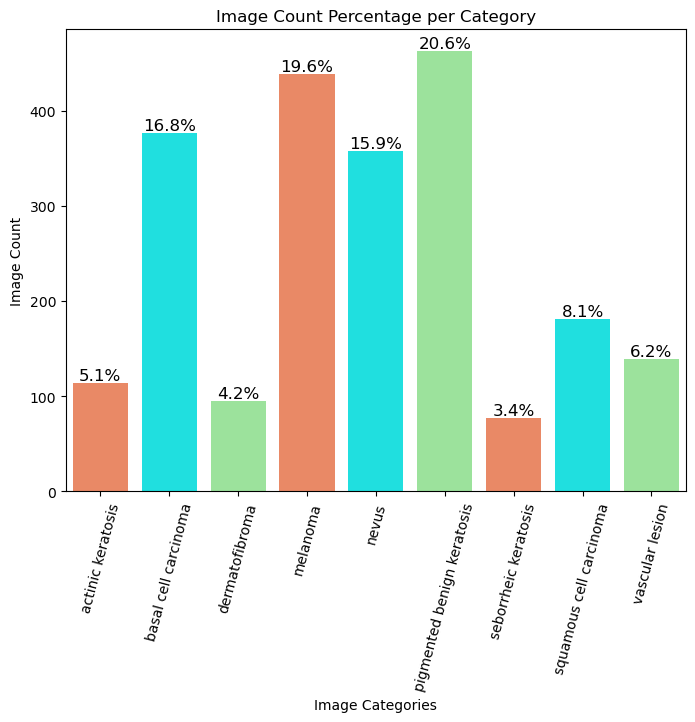

In [28]:
# Lets plot the count of classes for each class and check for any imbalance

# Compute total count
total = len(image_df)

# Create the plot
plt.figure(figsize=[8, 6])
ax = sns.countplot(
    x=image_df["Label"], 
    palette=["coral", "cyan", "lightgreen"], 
    order=sorted(image_df.Label.unique())
)

# Annotate bars with percentages
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'  # Calculate percentage
    x = p.get_x() + p.get_width() / 2  # X position
    y = p.get_height()  # Y position
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12, color='black')

plt.xlabel("Image Categories")
plt.xticks(rotation=75)
plt.ylabel("Image Count")
plt.title("Image Count Percentage per Category")
plt.show()

### Findings from checking the Class distribution 
#### - Which class has the least number of samples?
The "seborrheic keratosis" class has the least number of samples constituting 3.4% of total
#### - Which classes dominate the data in terms proportionate number of samples?
The "pigmented benign keratosis" class dominate the data in terms of samples constituting 20.6% of total


### Rectification of the class imbalance
#### **Context:** 
A python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) will be used to add more samples across all classes so that none of the classes have very few samples.

In [29]:
#!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset = "./Skin cancer ISIC The International Skin Imaging Collaboration/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) + "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x39E98E0C0>: 100%|████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 722.67 Samples/s]


Initialised with 376 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x39EA71CD0>: 100%|████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 718.92 Samples/s]


Initialised with 95 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x39C87ABD0>: 100%|████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 692.07 Samples/s]


Initialised with 438 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x39E905940>: 100%|██████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 151.16 Samples/s]


Initialised with 357 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1504x1129 at 0x39EA42ED0>: 100%|████████████████████████████████████████████| 500/500 [00:02<00:00, 203.16 Samples/s]


Initialised with 462 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x39E95B110>: 100%|████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 557.04 Samples/s]


Initialised with 77 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x39E701C40>: 100%|███████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 344.73 Samples/s]


Initialised with 181 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x39E9A4290>: 100%|████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 704.45 Samples/s]


Initialised with 139 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x39E5A2840>: 100%|████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 678.28 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [34]:
new_df = pd.DataFrame({'Path' : path_list_new, 
                      'Label' : lesion_list_new})
new_df.head()

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,melanoma
1,Skin cancer ISIC The International Skin Imagin...,melanoma
2,Skin cancer ISIC The International Skin Imagin...,melanoma
3,Skin cancer ISIC The International Skin Imagin...,melanoma
4,Skin cancer ISIC The International Skin Imagin...,melanoma


In [35]:
image_df_updated = pd.concat([image_df, new_df], axis=0)
image_df_updated

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,melanoma
1,Skin cancer ISIC The International Skin Imagin...,melanoma
2,Skin cancer ISIC The International Skin Imagin...,melanoma
3,Skin cancer ISIC The International Skin Imagin...,melanoma
4,Skin cancer ISIC The International Skin Imagin...,melanoma
...,...,...
4495,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
4496,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
4497,Skin cancer ISIC The International Skin Imagin...,dermatofibroma
4498,Skin cancer ISIC The International Skin Imagin...,dermatofibroma


In [36]:
image_df_updated['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

### Create a new training dataset with augmented images

In [38]:
data_dir_train = pathlib.Path('./Skin cancer ISIC The International Skin Imaging Collaboration/Train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Creation of third model with augmented images and normalization

In [ ]:
num_classes = len(class_names)

model = Sequential()

# Augmentation layer

model.add(image_augmentation)

# Input Layer
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))

# First Convolution layer with 16 filters of 3 X 3
model.add(layers.Conv2D(16, kernel_size = (3,3), padding = "same", activation = "relu"))

# Normalization layer
model.add(layers.BatchNormalization())

# Pooling Layer
model.add(layers.MaxPooling2D(pool_size = (2,2)))

# Second Convolution layer
model.add(layers.Conv2D(32, kernel_size =  (3,3), padding =  "same", activation = "relu"))

# Normalization layer
model.add(layers.BatchNormalization())

# Pooling Layer
model.add(layers.MaxPooling2D(pool_size = (2,2)))

# Dropout Layer
model.add(layers.Dropout(0.2))

# Third Convolution layer
model.add(layers.Conv2D(64, kernel_size =  (3,3), padding =  "same", activation = "relu"))

# Normalization layer
model.add(layers.BatchNormalization())

# Pooling Layer
model.add(layers.MaxPooling2D(pool_size = (2,2)))

# Dropout Layer
model.add(layers.Dropout(0.2))

# Flatten the image vector before passing to dense layer
model.add(layers.Flatten())

# Dense Fully Connected Layer
model.add(layers.Dense(128, activation = "relu"))

# Softmax Layer
model.add(layers.Dense(num_classes, activation = "softmax"))


### Compile model (Choosing optimizer and loss function appropriately)

In [40]:
# Adam optimiser and SparseCategoricalCrossEntropy loss function is chosen
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train model

In [41]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.4626 - loss: 1.4074 - val_accuracy: 0.4439 - val_loss: 1.5053
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.4747 - loss: 1.3587 - val_accuracy: 0.5249 - val_loss: 1.3418
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 87ms/step - accuracy: 0.4864 - loss: 1.3209 - val_accuracy: 0.5033 - val_loss: 1.3260
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.5114 - loss: 1.2784 - val_accuracy: 0.4395 - val_loss: 1.4566
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.4897 - loss: 1.3135 - val_accuracy: 0.5085 - val_loss: 1.3034
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.5108 - loss: 1.2624 - val_accuracy: 0.5167 - val_loss: 1.2514
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.5201 - loss: 1.2234 - val_accuracy: 0.5286 - val_loss: 1.2388
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.5422 - loss: 1.2006 - 

### Visualize the model results

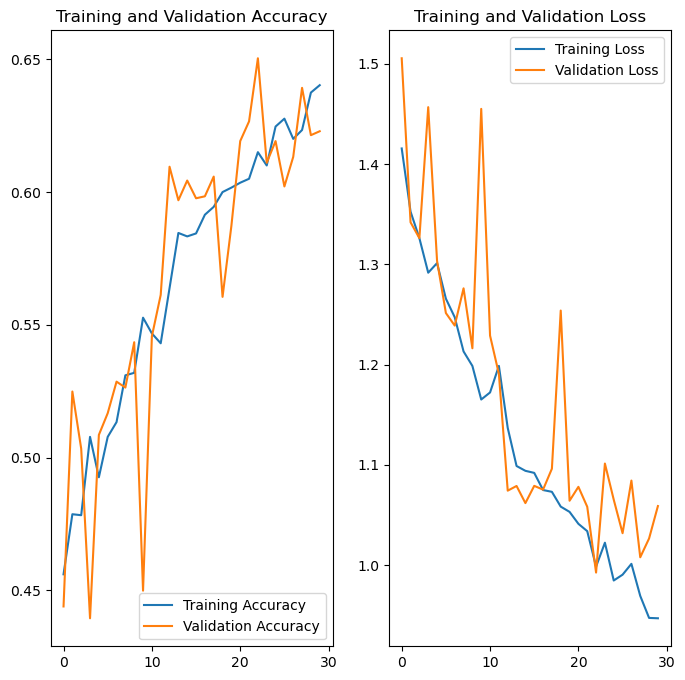

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Final Model Analysis



- The model has addressed overfitting issues as the training and validation scores are pretty close to each other. Thus the dropout and batch normalization strategies worked well
- The accuracy of the model has increased more than that of the previous models, so the data augmenation has also worked well
- The accuracy can potentially increase more if we add more augmented samples and do few more image transformations
- For melanoma detection we may also need to focus on recall scores instead of focusing on just accuracy